In [1]:
import librosa 
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import LearningCurveDisplay , ShuffleSplit
import lightgbm as lgb

In [2]:
indian_accent = os.path.join(os.getcwd(), "../data/raw/indian_accent/indian_accent_30.wav")
american_accent = os.path.join(os.getcwd(), '../data/raw/american_accent/american_accent_0.wav')
british_accent = os.path.join(os.getcwd(), '../data/raw/british_accent/british_accent_70.wav')

In [3]:
os.getcwd()

'c:\\Users\\hs787\\OneDrive\\Desktop\\MLOPS\\Accent-Recognition\\notebooks'

In [4]:
file_path = os.path.abspath(indian_accent)
print(file_path)

c:\Users\hs787\OneDrive\Desktop\MLOPS\Accent-Recognition\data\raw\indian_accent\indian_accent_30.wav


In [5]:
def plot_waveform(audio_path):
    audio, sr = librosa.load(audio_path)
    print(sr)
    plt.figure(figsize=(10, 4))
    plt.plot(audio)
    plt.title(f"Waveform of {os.path.basename(audio_path)}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

In [6]:
def listen_audio(audio_path):
    audio, sr = librosa.load(audio_path)
    return ipd.Audio(audio, rate=sr) 

In [7]:
listen_audio(indian_accent)

In [8]:
listen_audio(american_accent)

In [9]:
listen_audio(british_accent) 

22050


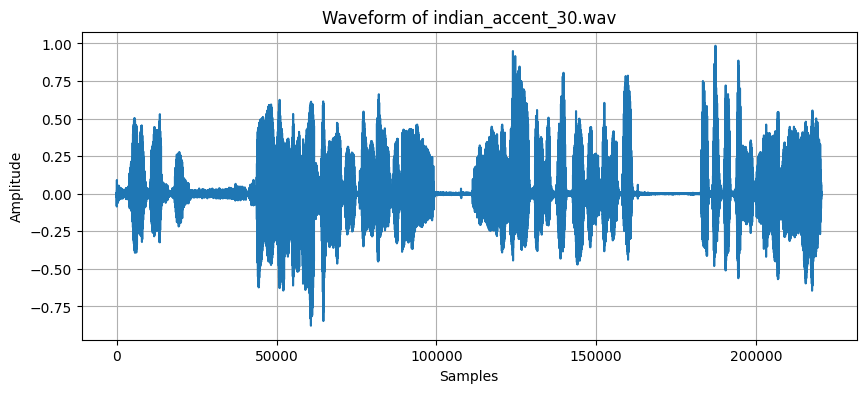

22050


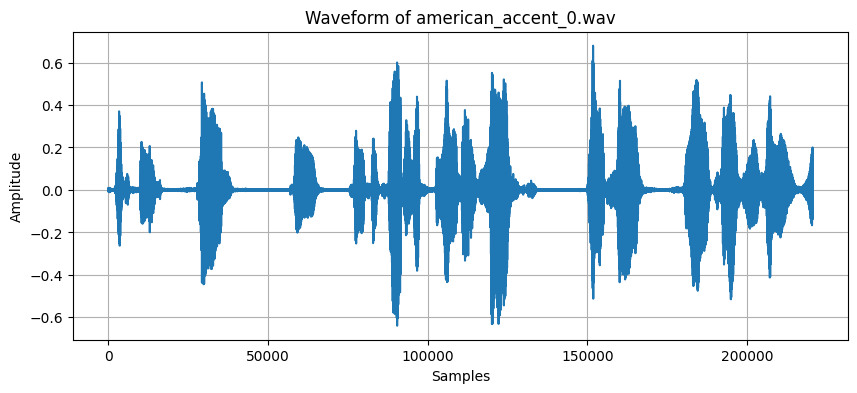

22050


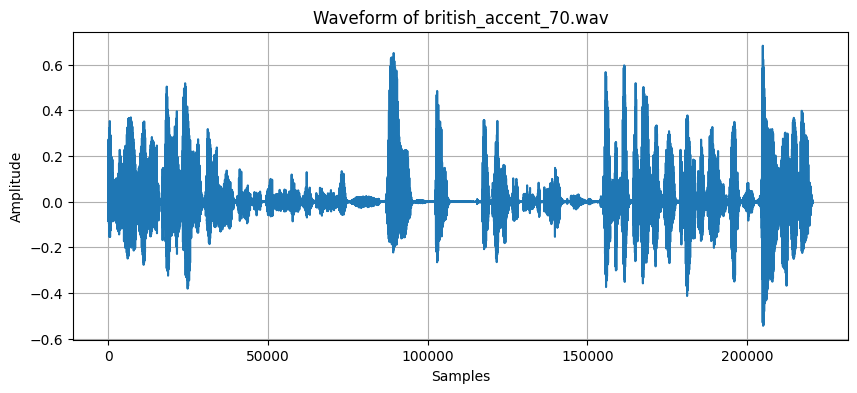

In [8]:
plot_waveform(indian_accent) 
plot_waveform(american_accent)
plot_waveform(british_accent)

In [13]:
def plot_spectrogram(audio_path):
    audio, sr = librosa.load(audio_path)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)**2), ref=np.max)
    plt.figure(figsize=(8, 3))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogram of {os.path.basename(audio_path)}")
    plt.show()

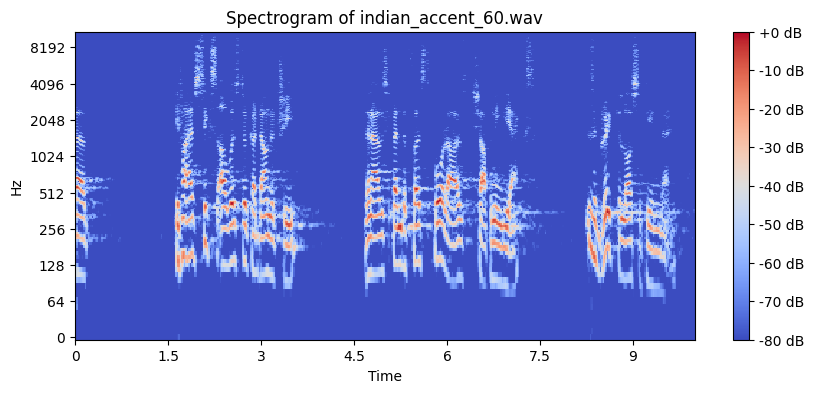

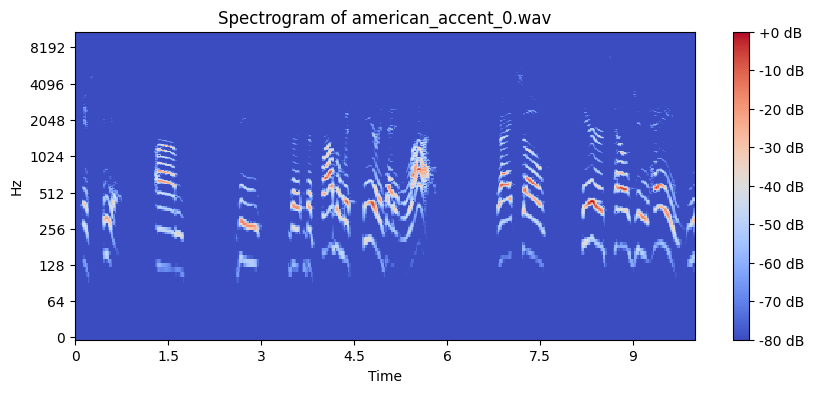

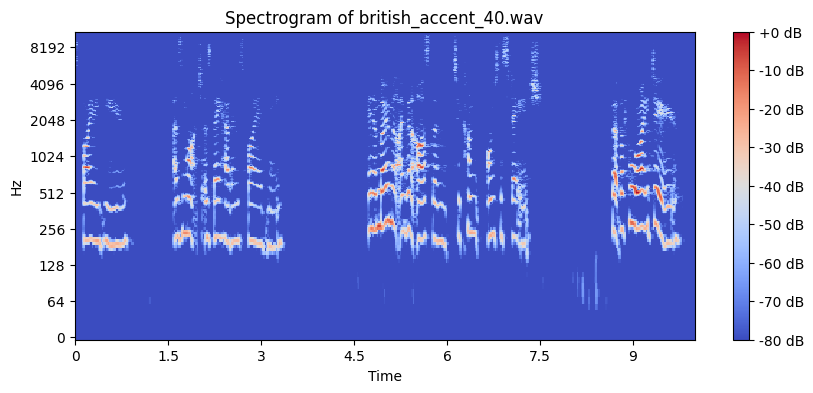

In [12]:
plot_spectrogram(indian_accent)
plot_spectrogram(american_accent)
plot_spectrogram(british_accent)

## Time Domain Features

Zero Crossing Rate

In [48]:
def plot_zero_crossing_rate(audio_path, label, ax):
    audio, sr = librosa.load(audio_path)
    zcr = librosa.feature.zero_crossing_rate(audio)[0]
    ax.plot(zcr, label=label)
    
    ax.grid()

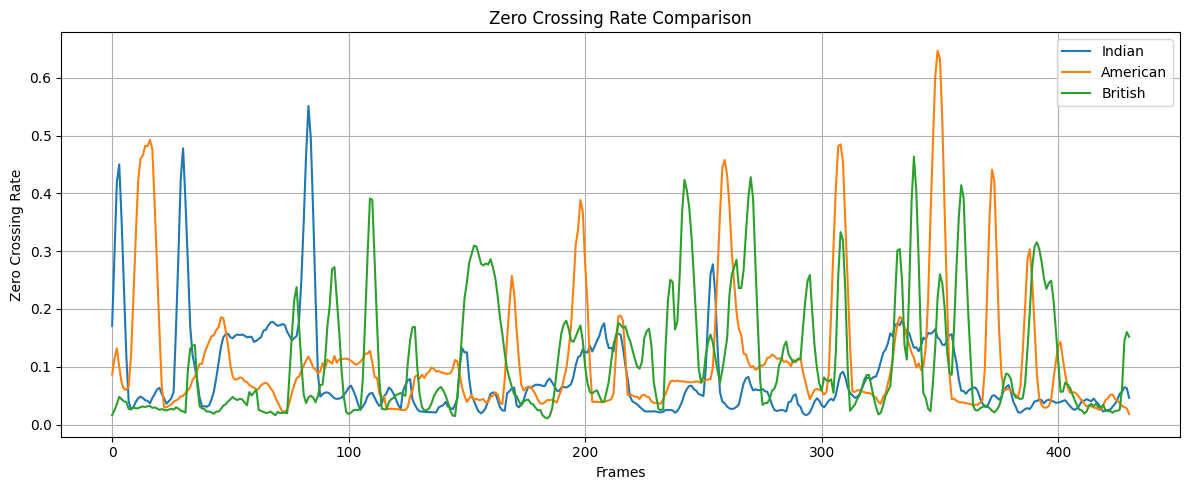

In [49]:
fig, ax = plt.subplots(figsize=(12, 5))

# Plot all ZCRs on the same axis
plot_zero_crossing_rate(indian_accent, "Indian", ax)
plot_zero_crossing_rate(american_accent, "American", ax)
plot_zero_crossing_rate(british_accent, "British", ax)

# Add labels, legend, title
ax.set_title("Zero Crossing Rate Comparison")
ax.set_xlabel("Frames")
ax.set_ylabel("Zero Crossing Rate")
ax.legend()
plt.tight_layout()
plt.show()

RMSE of signals

In [46]:
def plot_rmse(audio_path, label, ax):
    audio, sr = librosa.load(audio_path)
    rmse = librosa.feature.rms(y=audio)[0]  # safer to use `y=audio`
    ax.plot(rmse, label=label)
    ax.grid()

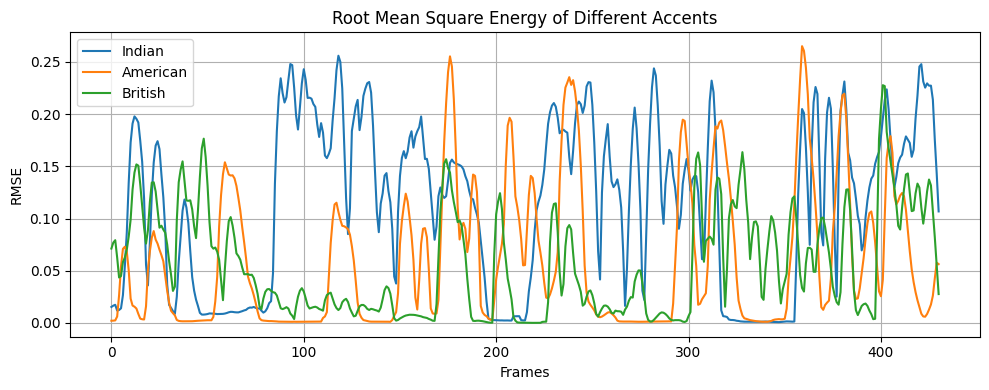

In [47]:
fig, ax = plt.subplots(figsize=(10, 4))

# Plot all RMSES on the same axis
plot_rmse(indian_accent, "Indian", ax)
plot_rmse(american_accent, "American", ax)
plot_rmse(british_accent, "British", ax)

# Add labels, legend, title
ax.set_title("Root Mean Square Energy of Different Accents")
ax.set_xlabel("Frames")
ax.set_ylabel("RMSE")
ax.legend()
plt.tight_layout()
plt.show()

## Frequency Domain Features

Band Energy Ratio 

In [28]:
HOP_LENGTH = 512 
FRAME_SIZE = 1024 

In [29]:
def create_split_freq_bin(spectrogram,fs,SPLIT_FREQ):
  freq_range = fs/2
  delta_freq = freq_range/spectrogram.shape[0]
  spli_freq_bin = int(SPLIT_FREQ/delta_freq)
  return spli_freq_bin


In [30]:
def band_energy_ratio(spectogram , fs, SPLIT_FREQ):
  split_freq_bin = create_split_freq_bin(spectogram,fs,SPLIT_FREQ)
  power_spec = np.abs(spectogram)**2
  power_spec = power_spec.T

  ber = []
  for freq_in_frame in power_spec:
    sum_power_low_freq = np.sum(freq_in_frame[:split_freq_bin])
    sum_power_high_freq = np.sum(freq_in_frame[split_freq_bin:])
    ber.append(sum_power_low_freq/sum_power_high_freq)
  return np.array(ber)


In [36]:
def plot_ber(audio_path, label, ax):
    sig, fs = librosa.load(audio_path)
    y = librosa.stft(sig, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
    t = librosa.frames_to_time(np.arange(y.shape[1]), sr=fs, hop_length=HOP_LENGTH)
    ber = band_energy_ratio(y, fs, SPLIT_FREQ=1028)
    ax.plot(t, ber, label=label)
    ax.grid()

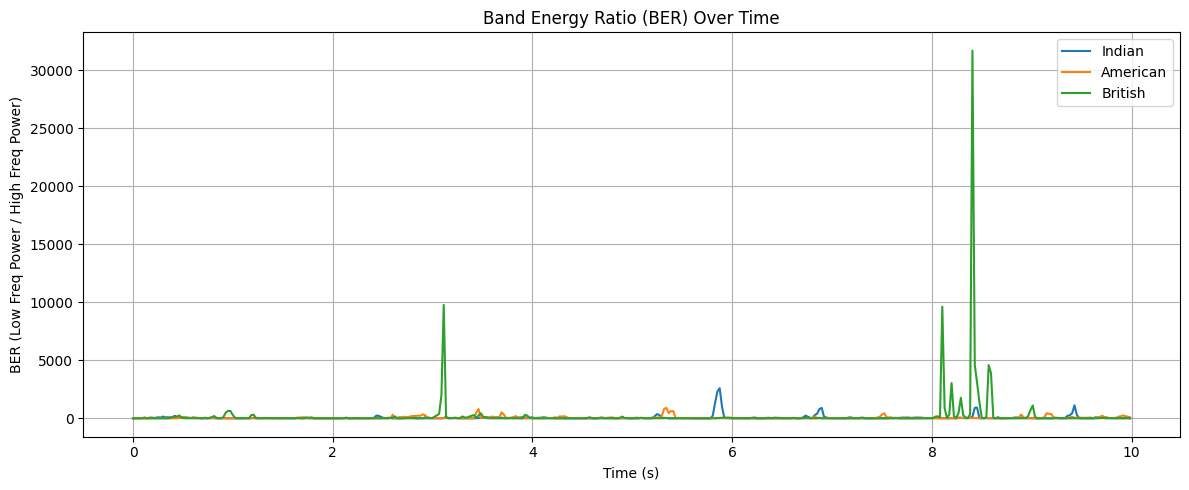

In [37]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_ber(indian_accent, "Indian", ax)
plot_ber(american_accent, "American", ax)
plot_ber(british_accent, "British", ax)

ax.set_title("Band Energy Ratio (BER) Over Time")
ax.set_xlabel("Time (s)")
ax.set_ylabel("BER (Low Freq Power / High Freq Power)")
ax.legend()
plt.tight_layout()
plt.show()

Bandwidth 

In [57]:
def plot_bandwidth(audio_path, label, ax):
    y, sr = librosa.load(audio_path)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    print(f"maximum_Bandwidth of {label} " , max(bandwidth) )
    print(f"minimum_Bandwidth of {label} " , min(bandwidth) )
    print(f"mean_Bandwidth of {label} " , np.mean(bandwidth) )
    t = librosa.frames_to_time(np.arange(len(bandwidth)), sr=sr)
    ax.plot(t, bandwidth, label=label)
    ax.grid()

maximum_Bandwidth of Indian  3644.013590641931
minimum_Bandwidth of Indian  856.2409629437024
mean_Bandwidth of Indian  1920.4312504019922
maximum_Bandwidth of American  3586.584451573608
minimum_Bandwidth of American  950.7527194347009
mean_Bandwidth of American  2066.8365929158176
maximum_Bandwidth of British  3501.5167398270055
minimum_Bandwidth of British  775.5680097188705
mean_Bandwidth of British  2003.5271106071239


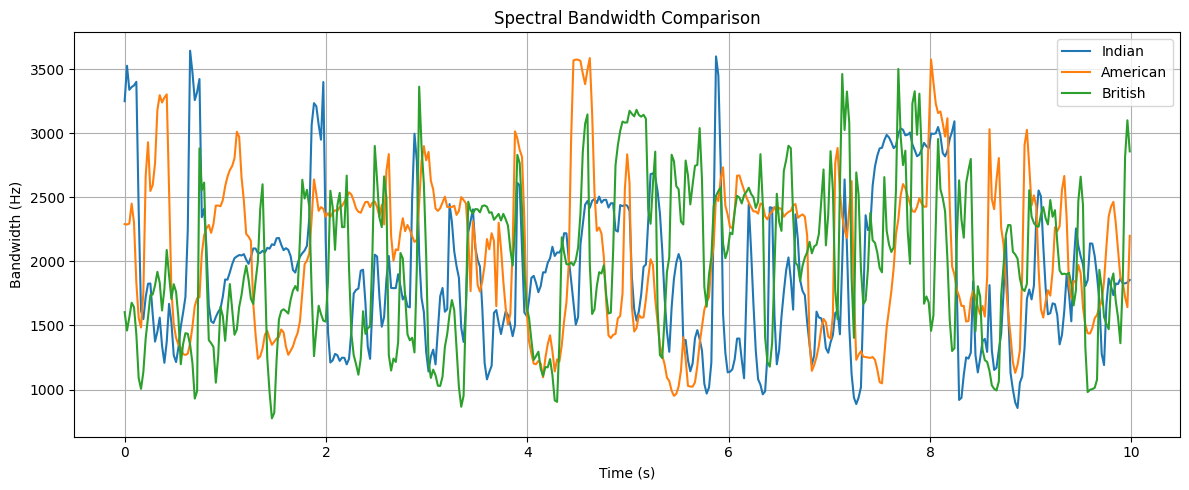

In [58]:
fig, ax = plt.subplots(figsize=(12, 5))

plot_bandwidth(indian_accent, "Indian", ax)
plot_bandwidth(american_accent, "American", ax)
plot_bandwidth(british_accent, "British", ax)

ax.set_title("Spectral Bandwidth Comparison")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Bandwidth (Hz)")
ax.legend()
plt.tight_layout()
plt.show()

Feature extraction 

In [9]:
def extract_features(audio_path):
    y, sr = librosa.load(audio_path)

    # Ensure minimum length by padding (optional but safer)
    if len(y) < 2048:
        y = np.pad(y, (0, 2048 - len(y)), mode='constant')

    # Parameters
    frame_length = 1024
    hop_length = 512

    # 1. MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=hop_length)
    mfccs_mean = np.mean(mfccs, axis=1)

    # 2. ZCR
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=frame_length, hop_length=hop_length)[0]
    zcr_mean = np.mean(zcr)

    # 3. RMSE
    rmse = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    rmse_mean = np.mean(rmse)

    # Combine all features
    features = list(mfccs_mean) + [zcr_mean, rmse_mean]
    return features


In [ ]:

# Initialize storage
feature_list = []
labels = []

# Loop through files
for i in range(90):
    for accent, label in [("Indian_accent", "Indian"), 
                          ("American_accent", "American"), 
                          ("British_accent", "British")]:
        prefix = accent.lower()
        file_path = os.path.join(os.getcwd(), f"../data/raw/{accent}/{prefix}_{i}.wav")
        
        if os.path.exists(file_path):
            features = extract_features(file_path)
            feature_list.append(features)
            labels.append(label)

# Create column names
mfcc_columns = [f"mfcc_{i+1}" for i in range(13)]
columns = mfcc_columns + ["zcr", "rmse"]

# Create dataframe
df = pd.DataFrame(feature_list, columns=columns)
df['label'] = labels

# Optional: Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())


       mfcc_1      mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6  \
0 -440.658539   42.738972 -10.813385  -5.301638  -9.464837 -11.768789   
1 -313.852081  100.427902   7.711929  28.537075  12.590288  21.334156   
2 -272.497345  106.350021  -5.170212   0.315210  -7.680429 -14.702052   
3 -233.781845  109.190506   2.687834  26.990917  18.253971 -16.489195   
4 -284.994812   96.948357  -5.880034   6.308382  -4.235891 -15.121429   

      mfcc_7     mfcc_8     mfcc_9    mfcc_10    mfcc_11    mfcc_12  \
0  -8.402801   4.636524  -5.336704  -2.360731  -7.157452  -8.319669   
1   1.495839  -8.088954 -11.297240  -9.678586 -12.806419  -1.910852   
2 -12.713369 -17.582325 -24.137398 -12.441595 -12.575592  -7.419004   
3 -29.332834  -8.383160 -18.719833  -8.848387 -12.173872 -10.365161   
4 -12.960493 -17.795643 -17.718748 -10.345438 -10.296411  -6.722870   

     mfcc_13       zcr      rmse    label  
0 -10.371439  0.280486  0.019631  British  
1  -7.284179  0.117163  0.021745  British  
2 

In [22]:
# 1. Features (X) and Labels (y)
X = df.drop('label', axis=1)
y = df['label']

# 2. Encode labels: "Indian" -> 0, "American" -> 1, "British" -> 2
le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [40]:
print(X.columns)

Index(['mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7',
       'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'zcr',
       'rmse'],
      dtype='object')


In [41]:
preprocessor = ColumnTransformer(transformers=[
    ('scaling', StandardScaler(), X.columns)
])

In [45]:
algorithms = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "lightGBM": lgb.LGBMClassifier(n_estimators=100, random_state=42) ,
    "LogisticRegression":LogisticRegression() 
}

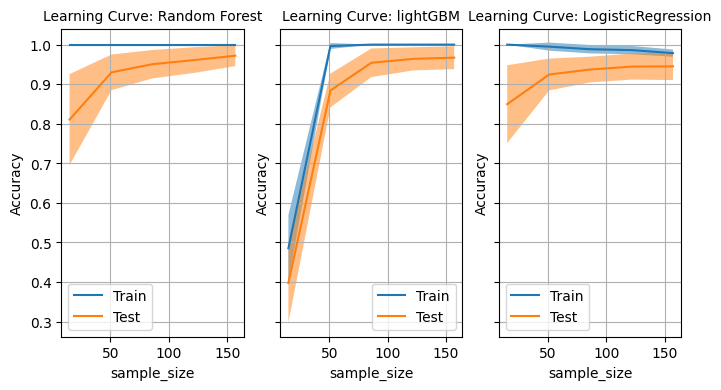

<Figure size 640x480 with 0 Axes>

In [49]:
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit, LearningCurveDisplay

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 4), sharey=True)

# algorithms should be a dictionary like: {"LightGBM": lgb_model, "Random Forest": rf_model}
for id, (name, model) in enumerate(algorithms.items()):
    
    # Fix: Add steps=[] to Pipeline
    classifier = Pipeline(steps=[
        ('trf1', preprocessor),
        ('clf', model)
    ])
    
    # Learning curve display
    LearningCurveDisplay.from_estimator(
        estimator=classifier,
        X=X,
        y=y_encoded,
        train_sizes=[0.1, 0.33, 0.55, 0.78, 1.0],
        cv=ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
        scoring='accuracy',
        n_jobs=-1,
        ax=ax[id]
    )

    ax[id].set_title(f"Learning Curve: {name}",fontsize=10)
    ax[id].set_xlabel("sample_size")
    ax[id].grid(True)

plt.show()
plt.tight_layout()


✅ Accuracy: 0.95

📋 Classification Report:
               precision    recall  f1-score   support

    American       1.00      0.88      0.93         8
     British       1.00      0.93      0.97        15
      Indian       0.89      1.00      0.94        17

    accuracy                           0.95        40
   macro avg       0.96      0.94      0.95        40
weighted avg       0.96      0.95      0.95        40



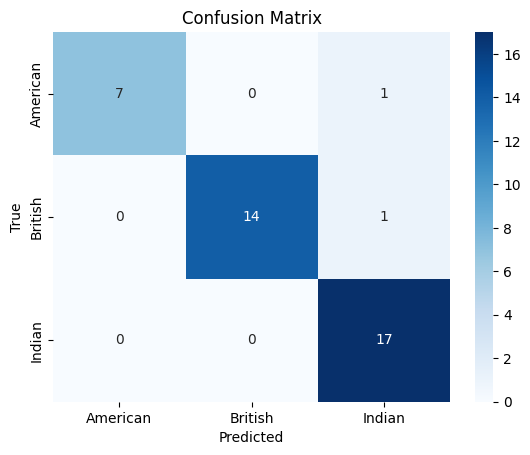

In [27]:
# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 4. Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 5. Predictions and Evaluation
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("✅ Accuracy:", accuracy)
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# 6. Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()